# Imports

In [1]:
from google.colab import drive
import sys
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torch
import torch.nn.functional as F
import torchtext

import seaborn as sns
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import time

cuda


# Mount Drive and set up directories

In [2]:
# Mount drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [3]:
# Copy dataset locally
!cp 'drive/MyDrive/CSCE-5290-project/indeed_dataset.csv' 'indeed_dataset.csv'

In [4]:
# Set up directories
path_to_project = 'drive/MyDrive/CSCE-5290-project'
path_to_results = os.path.join(path_to_project,'Results', 'Deep_Learning')
path_to_raw_dataset = 'indeed_dataset.csv'

In [5]:
path_to_results

'drive/MyDrive/CSCE-5290-project/Results/Deep_Learning'

# Load in the dataset and prepare the data

In [6]:
# Load in the data
raw_df = pd.read_csv(path_to_raw_dataset)

# Drop columns not used for the model
raw_df = raw_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'job_link'])
raw_df = raw_df.reset_index(drop=True)
raw_df = raw_df.dropna().drop_duplicates()
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14677 entries, 0 to 14813
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_id           14677 non-null  object
 1   job_title        14677 non-null  object
 2   location         14677 non-null  object
 3   experience       14677 non-null  object
 4   education        14677 non-null  object
 5   job_type         14677 non-null  object
 6   job_description  14677 non-null  object
dtypes: object(7)
memory usage: 917.3+ KB


In [7]:
# Take a look at the distribution of the data
for column in [x for x in raw_df.columns if x not in ['job_description']]:
  print(column)
  print(raw_df[column].value_counts())
  print()

job_id
2234aeb26fb8dcd1    15
561aa9e43fe57eaf    13
fa7a2a95e7d5ea3d    13
954176f960389df0    11
8fc75611d10238db    11
                    ..
edc4f5031bdfc20b     1
f22195f9c66bdd19     1
8fd27a178ad62377     1
4d23759984df3db5     1
819d606fb220e500     1
Name: job_id, Length: 7807, dtype: int64

job_title
Software Engineer            3587
Cloud Engineer               2913
Data Analyst                 1946
Data Architect               1496
Business Analyst             1327
Machine Learning Engineer    1028
Data Scientist                886
QA Engineer                   625
Data Engineer                 443
DevOps Engineer               318
QA Analyst                    108
Name: job_title, dtype: int64

location
Dallas, TX           3103
San Francisco, CA    2890
Chicago, IL          2014
Austin, TX           1870
Los Angeles, CA      1766
Seattle, WA          1652
San Diego, CA        1382
Name: location, dtype: int64

experience
MID_LEVEL       7610
SENIOR_LEVEL    5261
ENTRY_LEV

# Creating a Pytorch Dataset and Dataloader

In [8]:
FEATURE_COLUMN = 'job_description'
LABEL_COLUMN = 'experience'

In [9]:
# df_grouped = raw_df.groupby(['job_id', 'job_title']).agg({LABEL_COLUMN: set, 'job_description': 'first'}).reset_index()

In [10]:
# raw_df = df_grouped

In [11]:
# Creating tokenizer and vocab
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, raw_df[FEATURE_COLUMN]+" "+raw_df[LABEL_COLUMN].astype(str)), specials=['<unk>']) # , max_tokens=MAX_TOKENS)
vocab.set_default_index(vocab['<unk>'])

In [12]:
len(vocab)

65966

In [13]:
# Creating features column
raw_df['features'] = raw_df[FEATURE_COLUMN].map(lambda x: vocab(tokenizer(x)))

In [14]:
raw_df[['job_description', 'features']]

,job_description,features
0,"LIS Business Analyst (Austin, Texas) - job pos...","[11093, 29, 169, 14, 495, 1, 561, 13, 23, 20, ..."
1,Systems Operations Analyst - job post CEVA Log...,"[43, 204, 169, 23, 20, 102, 24782, 1888, 14, 1..."
2,Business Intelligence Analyst - job post Hire ...,"[29, 430, 169, 23, 20, 102, 672, 953, 495, 1, ..."
3,Business Analyst I - job post Silicon Labs Car...,"[29, 169, 708, 23, 20, 102, 2184, 2459, 1328, ..."
4,Business Intelligence Analyst - job post ABRAC...,"[29, 430, 169, 23, 20, 102, 7616, 1416, 17056,..."
...,...,...
14809,Sr. Full Stack Engineer - Remote - job post Sy...,"[571, 3, 283, 706, 69, 23, 183, 23, 20, 102, 5..."
14810,Oracle EBS Developer - Solution Manager - Loca...,"[831, 4642, 442, 23, 397, 403, 23, 130, 572, 2..."
14811,API Management Engineer - Senior Consultant (R...,"[821, 51, 69, 23, 132, 1355, 14, 183, 13, 23, ..."
14812,Sr. Ruby on Rails Developer - job post Medical...,"[571, 3, 2268, 19, 4512, 442, 23, 20, 102, 192..."


In [15]:
tokenized_df = raw_df.copy()
tokenized_df[LABEL_COLUMN] = pd.Categorical(raw_df[LABEL_COLUMN])
# raw_df[LABEL_COLUMN] = pd.Categorical(raw_df[LABEL_COLUMN], categories=['BACHELORS_DEGREE', 'MASTERS_DEGREE', 'DOCTORAL_DEGREE'])
tokenized_df['label'] = tokenized_df[LABEL_COLUMN].cat.codes
tokenized_df

,job_id,job_title,location,experience,education,job_type,job_description,features,label
0,d3fe7488bead34f4,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,"LIS Business Analyst (Austin, Texas) - job pos...","[11093, 29, 169, 14, 495, 1, 561, 13, 23, 20, ...",0
1,0c788d52c2a5420e,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,Systems Operations Analyst - job post CEVA Log...,"[43, 204, 169, 23, 20, 102, 24782, 1888, 14, 1...",0
2,ee82dee9280384d9,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,Business Intelligence Analyst - job post Hire ...,"[29, 430, 169, 23, 20, 102, 672, 953, 495, 1, ...",0
3,8df855078f305a53,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,Business Analyst I - job post Silicon Labs Car...,"[29, 169, 708, 23, 20, 102, 2184, 2459, 1328, ...",0
4,5a563d5d009c2306,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,Business Intelligence Analyst - job post ABRAC...,"[29, 430, 169, 23, 20, 102, 7616, 1416, 17056,...",0
...,...,...,...,...,...,...,...,...,...
14809,3ff0ac9115f15124,Software Engineer,"Seattle, WA",SENIOR_LEVEL,MASTERS_DEGREE,FULLTIME,Sr. Full Stack Engineer - Remote - job post Sy...,"[571, 3, 283, 706, 69, 23, 183, 23, 20, 102, 5...",2
14810,3e7a3c512c32b1e1,Software Engineer,"Seattle, WA",SENIOR_LEVEL,MASTERS_DEGREE,FULLTIME,Oracle EBS Developer - Solution Manager - Loca...,"[831, 4642, 442, 23, 397, 403, 23, 130, 572, 2...",2
14811,4caed4fe745916a8,Software Engineer,"Seattle, WA",SENIOR_LEVEL,MASTERS_DEGREE,FULLTIME,API Management Engineer - Senior Consultant (R...,"[821, 51, 69, 23, 132, 1355, 14, 183, 13, 23, ...",2
14812,082f08b79773672f,Software Engineer,"Seattle, WA",SENIOR_LEVEL,MASTERS_DEGREE,FULLTIME,Sr. Ruby on Rails Developer - job post Medical...,"[571, 3, 2268, 19, 4512, 442, 23, 20, 102, 192...",2


In [16]:
tokenized_df[[FEATURE_COLUMN, LABEL_COLUMN, 'features', 'label']]

,job_description,experience,features,label
0,"LIS Business Analyst (Austin, Texas) - job pos...",ENTRY_LEVEL,"[11093, 29, 169, 14, 495, 1, 561, 13, 23, 20, ...",0
1,Systems Operations Analyst - job post CEVA Log...,ENTRY_LEVEL,"[43, 204, 169, 23, 20, 102, 24782, 1888, 14, 1...",0
2,Business Intelligence Analyst - job post Hire ...,ENTRY_LEVEL,"[29, 430, 169, 23, 20, 102, 672, 953, 495, 1, ...",0
3,Business Analyst I - job post Silicon Labs Car...,ENTRY_LEVEL,"[29, 169, 708, 23, 20, 102, 2184, 2459, 1328, ...",0
4,Business Intelligence Analyst - job post ABRAC...,ENTRY_LEVEL,"[29, 430, 169, 23, 20, 102, 7616, 1416, 17056,...",0
...,...,...,...,...
14809,Sr. Full Stack Engineer - Remote - job post Sy...,SENIOR_LEVEL,"[571, 3, 283, 706, 69, 23, 183, 23, 20, 102, 5...",2
14810,Oracle EBS Developer - Solution Manager - Loca...,SENIOR_LEVEL,"[831, 4642, 442, 23, 397, 403, 23, 130, 572, 2...",2
14811,API Management Engineer - Senior Consultant (R...,SENIOR_LEVEL,"[821, 51, 69, 23, 132, 1355, 14, 183, 13, 23, ...",2
14812,Sr. Ruby on Rails Developer - job post Medical...,SENIOR_LEVEL,"[571, 3, 2268, 19, 4512, 442, 23, 20, 102, 192...",2


In [17]:
# df_grouped = raw_df.groupby(['job_id', 'job_title']).agg({'label': 'max', 'features': 'first'}).reset_index()

In [18]:
# raw_df = df_grouped

In [19]:
# raw_df

In [20]:
tokenized_df['label'].value_counts()

1    7610
2    5261
0    1806
Name: label, dtype: int64

Text(0, 0.5, 'Count')

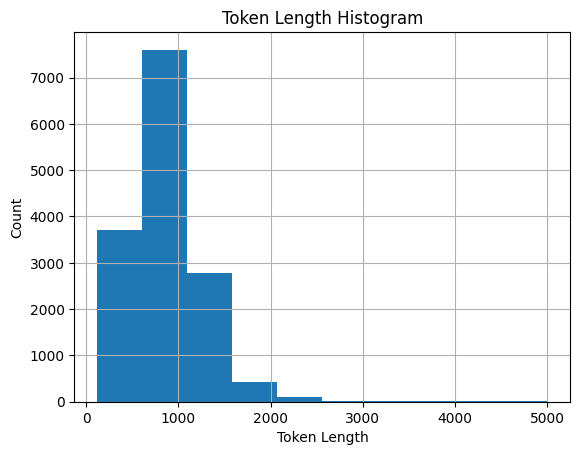

In [21]:
tokenized_df['lengths'] = tokenized_df['features'].map(lambda x: len(x))
tokenized_df['lengths'].hist()
plt.title('Token Length Histogram')
plt.xlabel('Token Length')
plt.ylabel('Count')

In [22]:
# Setting max tokens according to the distribution trying to preserve memory
MAX_TOKENS = 2000

In [23]:
class IndeedDataset(Dataset):
  ''' Indeed Jobs Dataset '''

  def __init__(self, pandas_dataframe, max_tokens):
    self.dataframe = pandas_dataframe
    self.max_tokens = max_tokens
  
  def __len__(self):
    return len(self.dataframe)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
            idx = idx.tolist()
    features = torch.tensor(self.dataframe['features'].iloc[idx])
    padded_features = F.pad(features, (1,self.max_tokens-len(features)), 'constant', 0)
    label = torch.tensor(self.dataframe['label'].iloc[idx], dtype=torch.long)
    return padded_features[:self.max_tokens], label
  
  def label(self):
    return self.dataframe[['label']]

In [24]:
# Creating the Dataset
# ds = IndeedDataset(raw_df, MAX_TOKENS)

In [25]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

X = tokenized_df # Contains all columns.
y = tokenized_df[['label']] # Dataframe of just the column on which to stratify.

# Stratified Sampling for train and val
df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                      y,
                                                      stratify=y,
                                                      test_size=0.2,
                                                      random_state=999)

# Split the temp dataframe into val and test dataframes.
df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                  y_temp,
                                                  stratify=y_temp,
                                                  test_size=0.5,
                                                  random_state=999)

In [26]:
training_data = IndeedDataset(df_train, MAX_TOKENS)
validation_data = IndeedDataset(df_val, MAX_TOKENS)
test_data = IndeedDataset(df_test, MAX_TOKENS)

In [27]:
torch.set_printoptions(precision=8)

In [28]:
class_sample_counts = [len([i for i in training_data if i[1]==t]) for t in range(len(tokenized_df['label'].unique()))]
weight = 1. / np.array(class_sample_counts)
samples_weight = np.array([weight[t[1]] for t in training_data], dtype=np.double)
samples_weight = torch.from_numpy(samples_weight)

sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [29]:
BATCH_SIZE = 64
# Creating the Data Loaders
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, sampler=sampler)
# train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [30]:
sample = next(iter(train_dataloader))
print( [len([i for i in sample[1] if i==t]) for t in range(len(tokenized_df['label'].unique()))] )

[18, 29, 17]


In [31]:
sample = next(iter(test_dataloader))
print(sample[1])

tensor([1, 0, 0, 0, 1, 0, 2, 1, 2, 1, 2, 1, 2, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1,
        2, 1, 0, 1, 0, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1])


# Model definition

In [32]:
class PositionalEncoding(nn.Module):
    '''
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    '''

    def __init__(self, d_model, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)                                      # initializing positional encoding
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)     # making a positions list (i)
        div_term = torch.exp(                                                   # another way of representing (1/10000)^2i/d but avoiding overflow using logs
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)                            # odd terms sin(k*(1/10000)^2i/d)
        pe[:, 1::2] = torch.cos(position * div_term)                            # even terms sin(k*(1/10000)^2i/d)
        pe = pe.unsqueeze(0)                                                    # adding dimension to match batch input
        self.register_buffer("pe", pe)                                          # registering to buffer to ensure its on the same device but not trainable

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]                                      # adding to the word embedding and truncating: (1, vocab_size, d_model)->(1, seq_len, d_model)
        return self.dropout(x)

In [33]:
from numpy.core.multiarray import dtype

class TransformerModel(nn.Module):

  def __init__(self, ntokens: int, d_model: int, nhead: int, d_hid: int,
               nlayers:int,nclasses:int, dropout: float = 0.6):
    super().__init__()
    self.model_type = 'Transformer'
    self.pos_encoder = PositionalEncoding(d_model, dropout=dropout, max_len=MAX_TOKENS)
    encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
    self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
    self.embedding = nn.Embedding(ntokens, d_model)
    self.d_model = d_model
    self.decoder = nn.Linear(d_model, nclasses)
    self.classifier = nn.Linear(nclasses*MAX_TOKENS, nclasses)

    self.init_weights()
  
  def init_weights(self) -> None:
    initrange = 0.1
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform_(-initrange, initrange)
    self.classifier.weight.data.uniform_(-initrange, initrange)
  
  def forward(self, x: Tensor) -> Tensor:
    # print('input', x.size())
    x = self.embedding(x) * math.sqrt(self.d_model)
    # print('embedding', x.size())
    x = self.pos_encoder(x)
    # print('pos encoder', x.size())
    x = self.transformer_encoder(x)
    # print('transformer', x.size())
    x = self.decoder(x)
    # print('decoder', x.size())
    x = x.view(x.shape[0], -1)
    # print('flattened', x.size())
    x = self.classifier(x)
    # print('classifier', x.size())
    return x

In [34]:
ntokens = len(vocab)
d_model = 100
d_hid = 200
nlayers = 8
nhead = 4
dropout = 0.1
nclasses = len(tokenized_df['label'].unique())

model = TransformerModel(ntokens, d_model, nhead, d_hid, nlayers, nclasses, dropout).to(device)

In [35]:
print(f"ntokens: {ntokens} d_model {d_model}, nhead {nhead}, d_hid {d_hid}, nlayers {nlayers}, dropout {dropout}, nclasses {nclasses}")

ntokens: 65966 d_model 100, nhead 4, d_hid 200, nlayers 8, dropout 0.1, nclasses 3


In [36]:
print("Custom Transformer Number of Parameters:",sum(p.numel() for p in model.parameters()))

Custom Transformer Number of Parameters: 7263706


In [37]:
print(model)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=200, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=200, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (embedding): Embedding(65966, 100)
  (decoder): Linear(in_features=100, out_features=3, bias=True)
  (classifier): Linear(in_features=6000, out_features=3, bias=True)
)


# Define the training loop

In [38]:
def evaluate(model: nn.Module, eval_data) -> float:
  criterion = nn.CrossEntropyLoss()
  model.eval()  # turn on evaluation mode
  total_loss = 0.
  with torch.no_grad():
    for features, labels in eval_data:
      features = features.to(device)
      labels = labels.to(device)
      output = model(features)
      output_flat = output.view(-1, nclasses)
      total_loss += criterion(output_flat, labels).item()
  return total_loss / (len(eval_data) - 1)

In [39]:
# looking at the data and pretraining results
first,*_ = train_dataloader
input = first[0]
labels = first[1]
output = model(input.to(device))
print('input',input)
# print('out', output)
print('output', torch.argmax(output, dim=1))
print('labels', labels)

input tensor([[  0, 542,  33,  ...,   0,   0,   0],
        [  0, 403,   1,  ...,   0,   0,   0],
        [  0, 132, 774,  ...,   0,   0,   0],
        ...,
        [  0,  82, 403,  ...,   0,   0,   0],
        [  0, 121,  72,  ...,   0,   0,   0],
        [  0, 107, 100,  ...,   0,   0,   0]])
output tensor([2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2,
        1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1,
        2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2], device='cuda:0')
labels tensor([0, 1, 2, 2, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 1, 2, 0, 2, 2,
        2, 1, 0, 0, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 0, 1, 0, 1, 2, 1,
        1, 1, 0, 2, 2, 2, 0, 0, 2, 1, 1, 1, 1, 1, 1, 0])


In [52]:
best_model_params_path = os.path.join(path_to_project,'models', f"{LABEL_COLUMN}_best_custom_transformer_{d_model}_{nhead}_{nlayers}_{d_hid}.pt")

def train(dataloader, num_epochs, lr, log_interval, early_stopping_tolerance, 
          d_model=100, nhead=2, d_hid=100, nlayers=2, save_path="transformer.pt"
          ,history = {'training_loss': [], 'validation_loss': []}):
  best_val = 1.3
  # model = TransformerModel(ntokens, d_model, nhead, d_hid, nlayers, nclasses, 0.1).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
  for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()
    model.train()
    total_loss = 0.
    start_time = time.time()
    num_batches = len(training_data) // BATCH_SIZE
    curr_loss = 0
    for i, (features, labels) in enumerate(dataloader):
      labels = labels.to(device)
      features = features.to(device)
      output = model(features)
      loss = criterion(output.view(-1, nclasses), labels)
      *_, last = model.parameters()
      optimizer.zero_grad()

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()
      total_loss += loss.item()
      if (log_interval and i % log_interval == 0 and i > 0):
        lr = scheduler.get_last_lr()[0]
        ms_per_batch = (time.time() - start_time) * 1000 / log_interval
        curr_loss = total_loss / log_interval
        print(f'| epoch {epoch:3d} | {i:5d}/{num_batches} | batch size {len(labels)} | '
              f'lr {lr:02.3f} | ms/batch {ms_per_batch:5.2f} | '
              f'loss {curr_loss:5.2f}')
        total_loss = 0
        start_time = time.time()
    first,*_ = test_dataloader
    output = model(first[0].to(device))
    val_loss = evaluate(model, validation_dataloader)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
        f'training loss {curr_loss:5.2f} | valid loss {val_loss:5.2f}')
    print('-' * 89)
    history['training_loss'].append(curr_loss)
    history['validation_loss'].append(val_loss)
    if (val_loss - curr_loss > early_stopping_tolerance and epoch > 5):
      print('early stopping')
      break
    scheduler.step()
    if (val_loss < best_val):
      torch.save(model.state_dict(), best_model_params_path)
      best_val = val_loss
  return model, history

# Training

## Hyper param tuning

In [41]:
import random

def random_grid_search(function, param_grid, dataloader, num_epochs, log_interval, early_stopping_tolerance, itter, previous_results = {}):
  results = previous_results
  for i in range(itter):
    lr = random.sample(param_grid['lr'], 1)[0]
    d_model = random.sample(param_grid['d_model'], 1)[0]
    nhead = random.sample(param_grid['nhead'], 1)[0]
    d_hid = random.sample(param_grid['d_hid'], 1)[0]
    n_layers = random.sample(param_grid['n_layers'], 1)[0]
    config = f"{lr}_{d_model}_{nhead}_{d_hid}_{n_layers}"
    model_path = os.path.join(path_to_project,'models', f"{config}.pt")
    history_path = os.path.join(path_to_project,'models', f"{config}_hist.npy")
    print(config)
    if(config not in results):
      model, history = function(dataloader, num_epochs, lr, log_interval, early_stopping_tolerance, d_model, nhead, d_hid, nlayers, model_path)
      torch.save(model.state_dict(), best_model_params_path)
      with open(history_path, 'wb') as f:
        np.save(f, history)
      results[config] = {"history": history, "model": model_path}
  return results

In [42]:
# param_grid = {'lr': [0.001,0.0001],
#               'd_model': [100, 200],
#               'nhead': [2,4],
#               'd_hid': [100, 200],
#               'n_layers': [2,3,4]}

# results = random_grid_search(train, param_grid, train_dataloader, 20, 80, 0.0, 10, results)

In [43]:
# results

In [44]:
# for k,v in results.items():
#   history_df = pd.DataFrame(v['history'])
#   history_df.plot()
#   plt.xlabel('epochs')
#   plt.ylabel('loss')
#   plt.title(f'Loss vs. Epoch for "{LABEL_COLUMN}" column, {k}')
#   plt.savefig(f'{path_to_results}/trainig_{LABEL_COLUMN}_ct_{k}.png')
#   plt.show()

## Classic Training

In [45]:
BATCH_SIZE = 64
# Creating the Data Loaders
# train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, sampler=sampler)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
history = {'training_loss': [], 'validation_loss': []}
model = TransformerModel(ntokens, d_model, nhead, d_hid, nlayers, nclasses, dropout).to(device)

In [53]:
num_epochs = 10
log_interval = 60
lr = 0.000005
early_stopping_tolerance = 0.4
ntokens = len(vocab)
d_model = 200
d_hid = 200
nlayers = 8
nhead = 8
dropout = 0.2
nclasses = len(tokenized_df['label'].unique())

model, history = train(train_dataloader, num_epochs, lr, log_interval, early_stopping_tolerance, d_model, nhead, d_hid, nlayers, history)

| epoch   1 |    60/183 | batch size 64 | lr 0.000 | ms/batch 325.66 | loss  1.45
| epoch   1 |   120/183 | batch size 64 | lr 0.000 | ms/batch 319.88 | loss  1.38
| epoch   1 |   180/183 | batch size 64 | lr 0.000 | ms/batch 320.12 | loss  1.34
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 61.30s | training loss  1.34 | valid loss  1.30
-----------------------------------------------------------------------------------------
| epoch   2 |    60/183 | batch size 64 | lr 0.000 | ms/batch 325.76 | loss  1.34
| epoch   2 |   120/183 | batch size 64 | lr 0.000 | ms/batch 320.09 | loss  1.32
| epoch   2 |   180/183 | batch size 64 | lr 0.000 | ms/batch 320.32 | loss  1.29
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 61.33s | training loss  1.29 | valid loss  1.25
----------------------------------------------------------------------------------------

KeyboardInterrupt: ignored

In [47]:
best_model_params_path = os.path.join(path_to_project,'models', f"{LABEL_COLUMN}_best_custom_transformer_{d_model}_{nhead}_{nlayers}_{d_hid}.pt")
model.load_state_dict(torch.load(best_model_params_path))

FileNotFoundError: ignored

In [48]:
history_df = pd.DataFrame(history)

In [49]:
path_to_results='/content/drive/MyDrive/CSCE-5290-project/Results/Deep_Learning'

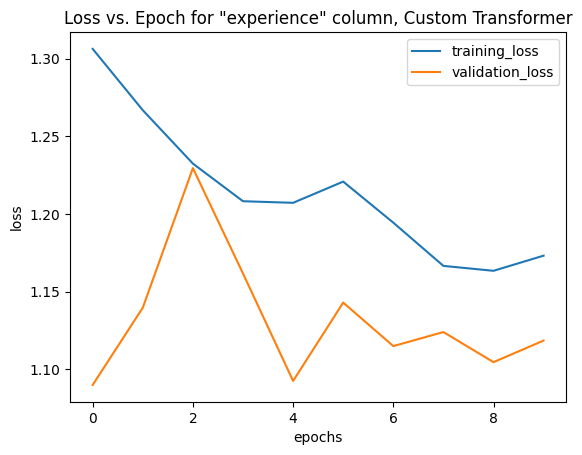

In [50]:
history_df.plot()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title(f'Loss vs. Epoch for "{LABEL_COLUMN}" column, Custom Transformer')
plt.savefig(f'{path_to_results}/trainig_{LABEL_COLUMN}_Custom_Transformer_2.png')
plt.show()

Classification Report for "experience" column, Custom Transformer:
              precision    recall  f1-score   support

           0       0.20      0.42      0.27       181
           1       0.54      0.52      0.53       761
           2       0.43      0.28      0.34       526

    accuracy                           0.42      1468
   macro avg       0.39      0.41      0.38      1468
weighted avg       0.46      0.42      0.43      1468

Confusion Matrix:


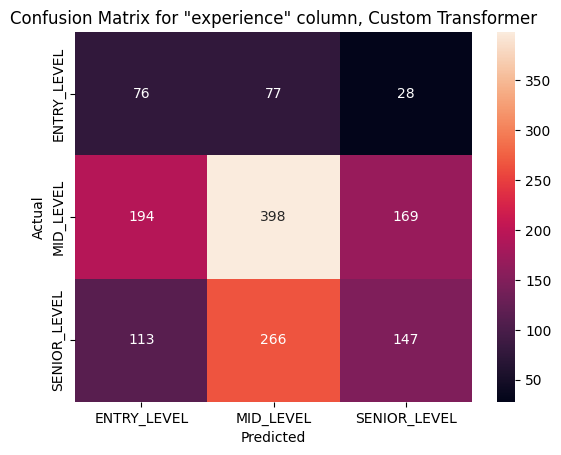

In [51]:
from sklearn.metrics import confusion_matrix, classification_report

# Set the model to evaluation mode
model.eval()

# Initialize variables for storing predictions and labels
all_preds = []
all_labels = []

# Iterate over batches in the test data loader
for features, labels in test_dataloader:
    # Get the input features and labels
    features = features.to(device)
    labels = labels.to(device)
    # print(features, labels)

    # Make predictions
    with torch.no_grad():
        preds = model(features)
        # print('raw', preds)
        preds = torch.argmax(preds, dim=1)
        # print('argmax', preds)
        # print('labels', labels)

    # Append predictions and labels to the lists
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Get the confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds)

# Print the confusion matrix and classification report
print(f'Classification Report for "{LABEL_COLUMN}" column, Custom Transformer:')
print(report)
print("Confusion Matrix:")
# print(cm)
sns.heatmap(cm, annot=True, fmt='1',\
            yticklabels=list(tokenized_df[LABEL_COLUMN].cat.categories),\
            xticklabels=list(tokenized_df[LABEL_COLUMN].cat.categories))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for "{LABEL_COLUMN}" column, Custom Transformer')
plt.savefig(f'{path_to_results}/confusion_{LABEL_COLUMN}_Custom_Transformer_2.png')
plt.show()

# Using the model to infer from sentences

In [ ]:
def infer(text):
  fake_job_description_tokens = vocab(tokenizer(text))
  features = torch.tensor(fake_job_description_tokens)
  padded_features = F.pad(features, (0,MAX_TOKENS-len(features)), 'constant', 0)
  output = model(torch.unsqueeze(padded_features.to(device), dim=0))
  return output

In [ ]:
description = "Basic Qualifications 5 or more years of relevant work experience with a Bachelors Degree or at least 2 years of work experience with an Advanced degree (e.g. Masters, MBA, JD, MD) or 0 years of work experience with a PhD Preferred Qualifications 7 – 10 years of relevant work experience or 4 – 5 years relevant work experience and bachelor’s degree in data analytics, information management or related field. Experience in a highly analytical, results-oriented environment with cross functional interactions. Strong analytical, mediation and problem resolution skills Highly proficient in Microsoft Excel, PowerPoint, Word. Additional knowledge of other MS 365 applications is beneficial Demonstrable knowledge of data visualization tools (e.g., Tableau, Power BI, MicroStrategy) Excellent time management, communication, collaboration and organization skills Good business acumen to orient data analysis and solutions to business needs of clients Excellent communication skills with ability to translate data and technical concepts for a non-technical audience Team oriented, energetic, collaborative, diplomatic and flexible Intellectually curious and continuously"
infer(description)

In [ ]:
description = "Sr. Analyst, Business Strategy & Operations (Hybrid/Onsite) - job post Visa 1,066 reviews Austin, TX • Hybrid remote Full-time You must create an Indeed account before continuing to the company website to apply Apply on company site save-icon Job details Encouraged to Apply Fair chance Job Type Full-time Company Description Visa is a world leader in digital payments, facilitating more than 215 billion payments transactions between consumers, merchants, financial institutions and government entities across more than 200 countries and territories each year. Our mission is to connect the world through the most innovative, convenient, reliable and secure payments network, enabling individuals, businesses and economies to thrive. When you join Visa, you join a culture of purpose and belonging – where your growth is priority, your identity is embraced, and the work you do matters. We believe that economies that include everyone everywhere, uplift everyone everywhere. Your work will have a direct impact on billions of people around the world – helping unlock financial access to enable the future of money movement. Join Visa: A Network Working for Everyone. Job Description Position Summary In this role, you will partner with the Architecture Leadership Team, Architects, Project Management Office (PMO), Business Partners and others to manage and optimize our tools, processes, reporting and workflow. You will manage the team’s work effort intake, establish a capacity management and reporting framework, drive data quality compliance and provide guidance on best practices. Once optimal tools, processes, reporting and workflow are established and baselined, the responsibilities will shift to managing and maintaining structure and consistency across team initiatives, driving collaboration, innovation, training and organizational reporting. Essential Functions Primary Collect, analyze and report on resource capacity and drawdown to demonstrate progress against planned goals and deliverables. Collaborate with the PPD PMO and PPD Front Door to assign Projects and Change Controls to Architecture Domain leads for Evaluation, monitor the work queues and ensure SLAs are being met. Work with the Architecture & Consulting resource managers to assign projects to Architects leveraging capacity reporting to identify available bandwidth and expertise. Monitor team tools, processes, and artifacts for data quality, including Jira, Wiki, SharePoint and OneDrive and work with the team members to produce compliance artifacts. Drive Architecture & Consulting compliance with team processes. Manage and maintain consistent and effective dashboards, scorecards and reports around team metrics and initiatives. Build / customize / maintain automation workflows to continually improve processes and data quality. Document processes for knowledge transfer and continuity planning. Identify and implement opportunities for further enhancements and refinements to tools, standards and processes across the team. Act as a change evangelist for the team as new processes, tools and workflows are established. Additional Manage the structure and content look and feel of the Architecture and Consulting wiki pages. Provide guidance to team on content creation, including templates and macro usage. Develop and facilitate collaboration sessions across with PPD development teams, maintain relevant artifacts and agendas. Support the creation, maintenance, and delivery of material for both technical and non-technical training and knowledge-sharing needs. Maintain online training course archive and repository of all training materials Recommend improvements to existing training programs and processes, and assist with the implementation and enhancement of those programs and processes Design and implement metrics to measure impact, effectiveness, appropriateness, and utility Generate scheduled and ad-hoc management and organizational reports, highlighting progress on key initiates. This is a hybrid position. Hybrid employees can alternate time between both remote and office. Employees in hybrid roles are expected to work from the office 2-3 set days a week (determined by leadership/site), with a general guidepost of being in the office 50% or more of the time based on business needs. PLEASE NOTE: NO SPONSORSHIP, NO RELOCATION SUPPORTED FOR THIS ROLE Qualifications Basic Qualifications 5 or more years of relevant work experience with a Bachelors Degree or at least 2 years of work experience with an Advanced degree (e.g. Masters, MBA, JD, MD) or 0 years of work experience with a PhD Preferred Qualifications 7 – 10 years of relevant work experience or 4 – 5 years relevant work experience and bachelor’s degree in data analytics, information management or related field. Experience in a highly analytical, results-oriented environment with cross functional interactions. Strong analytical, mediation and problem resolution skills Highly proficient in Microsoft Excel, PowerPoint, Word. Additional knowledge of other MS 365 applications is beneficial Demonstrable knowledge of data visualization tools (e.g., Tableau, Power BI, MicroStrategy) Excellent time management, communication, collaboration and organization skills Good business acumen to orient data analysis and solutions to business needs of clients Excellent communication skills with ability to translate data and technical concepts for a non-technical audience Team oriented, energetic, collaborative, diplomatic and flexible Intellectually curious and continuously striving to learn Ability to work independently, yet seamlessly integrate activities with other teams when needed Good judgment, strong common sense and excellent attention to detail Proactive and solution-oriented, solid analytical and problem-solving skills and ability to think strategically Actively promotes an environment with psychological safety and contributes to a culture of inclusion Highly Desirable / Beneficial Experience creating workflows with no code applications (e.g., Jira, Power Automate) Experience developing applications in MS Visual Basic, Python or JavaScript Experience in the Payments and/or Technology industry Knowledge of project management and/or information management Experience with Visa’s process, platforms and products Knowledge of SDLC and Agile / Lean methodologies Additional Information Work Hours: Varies upon the needs of the department. Travel Requirements: This position requires travel 5-10% of the time. Mental/Physical Requirements: This position will be performed in an office setting. The position will require the incumbent to sit and stand at a desk, communicate in person and by telephone, frequently operate standard office equipment, such as telephones and computers. Visa is an EEO Employer. Qualified applicants will receive consideration for employment without regard to race, color, religion, sex, national origin, sexual orientation, gender identity, disability or protected veteran status. Visa will also consider for employment qualified applicants with criminal histories in a manner consistent with EEOC guidelines and applicable local law. Visa will consider for employment qualified applicants with criminal histories in a manner consistent with applicable local law, including the requirements of Article 49 of the San Francisco Police Code. U.S. APPLICANTS ONLY: The estimated salary range for a new hire into this position is 101,800.00 to 132,300.00 USD, which may include potential sales incentive payments (if applicable). Salary may vary depending on job-related factors which may include knowledge, skills, experience, and location. In addition, this position may be eligible for bonus and equity.Visa has a comprehensive benefits package for which this position may be eligible that includes Medical, Dental, Vision, 401 (k), FSA/HSA, Life Insurance, Paid Time Off, and Wellness Program"
# description = "Basic Qualifications 5 or more years of relevant work experience with a Bachelors Degree or at least 2 years of work experience with an Advanced degree (e.g. Masters, MBA, JD, MD) or 0 years of work experience with a PhD Preferred Qualifications 7 – 10 years of relevant work experience or 4 – 5 years relevant work experience and bachelor’s degree in data analytics, information management or related field. Experience in a highly analytical, results-oriented environment with cross functional interactions. Strong analytical, mediation and problem resolution skills Highly proficient in Microsoft Excel, PowerPoint, Word. Additional knowledge of other MS 365 applications is beneficial Demonstrable knowledge of data visualization tools (e.g., Tableau, Power BI, MicroStrategy) Excellent time management, communication, collaboration and organization skills Good business acumen to orient data analysis and solutions to business needs of clients Excellent communication skills with ability to translate data and technical concepts for a non-technical audience Team oriented, energetic, collaborative, diplomatic and flexible Intellectually curious and continuously"
for i in range(10, len(description), 10):
  output = infer(description[:i])
  print(i, description[i-50:i])
  print(output)
  prediction = torch.argmax(output).item()
  if(prediction == 2):
    # label = raw_df[LABEL_COLUMN].cat.categories[prediction]
    print(i, description[:i])
    break

In [ ]:
fake_job_description = "we are looking for someone with 20 years of experience"
for i in range(len(raw_df[raw_df[LABEL_COLUMN] =='SENIOR_LEVEL']['job_description'])):
  input = raw_df[raw_df[LABEL_COLUMN] =='SENIOR_LEVEL']['job_description'].iloc[i]
  fake_job_description = input
  # print(fake_job_description)
  fake_job_description_tokens = vocab(tokenizer(fake_job_description))
  # print(fake_job_description_tokens)
  features = torch.tensor(fake_job_description_tokens)
  # print(features)
  padded_features = F.pad(features, (0,MAX_TOKENS-len(features)), 'constant', 0)
  # print(padded_features)
  # print(sum(padded_features))
  output = model(torch.unsqueeze(padded_features.to(device), dim=0))
  # print(output)
  prediction = torch.argmax(output).item()
  
  raw_df[LABEL_COLUMN][prediction]
  if(prediction == 2):
    print(prediction)
    print(input)
    description = input
    break